In [28]:
import numpy as np
from  scipy.misc import imresize
from scipy.misc import imsave
from scipy.ndimage import imread
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [29]:
M, N = 64,64
imageSize = (M, N)

### Functions: 

In [30]:
def calLoss(moving, reference):
    return np.sum((moving-reference)**2)

In [31]:
def getCoorMatrix(imageShape):
    yShape, xShape = imageSize
    coorMatrix = np.asarray(np.meshgrid(np.arange(xShape), np.arange(yShape)))
    coorMatrix = np.rollaxis(coorMatrix, 0, 3)
    return coorMatrix
    

In [32]:
def getFourCorners(transformMatrix):
    # 1. calculat the coordinate matrix
    yShape, xShape = imageSize
    coorMatrix = getCoorMatrix(imageSize)
    onesMatrix = np.ones(imageSize).reshape(yShape, xShape, 1)
    coorMatrix = np.concatenate((coorMatrix, onesMatrix), axis=2)
    # 2. transformed coordinate matrix of transformed Matrix
    projectMatrix = np.dot(coorMatrix, transformMatrix.T) 
    
    # 3. set out of boundary points to zeros
    projectMatrix[projectMatrix<0] = 0
    x_matrix, y_matrix = projectMatrix[:,:,0], projectMatrix[:, :, 1]
    x_matrix[x_matrix>N-2] = 0 # maybe consider later
    y_matrix[y_matrix>M-2] = 0
    projectMatrix[:,:,0], projectMatrix[:, :, 1] = x_matrix.reshape(M,N), y_matrix.reshape(M,N)
    # 4. build nearby 4 point
    ULmatrix = np.floor(projectMatrix[:,:,0:2]).astype(int)
    DLmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]+1).reshape(M, N, 1)), axis=2).astype(int)
    URmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]+1).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]).reshape(M, N, 1)), axis=2).astype(int)
    DRmatrix = np.floor(projectMatrix[:,:,0:2]+1).astype(int)
    cornerMatrixes = [ULmatrix, URmatrix, DLmatrix, DRmatrix] # UpLeft, UpRight, DownLeft, DownRight
    return cornerMatrixes, projectMatrix

<h3>Interpolate Method</h3>
<img src="img/interpolate.png" width="20%" height="20%">
<img src="img/interpolate_method.png" width="40%" height="40%">
<img src="img/image_gradient.png" width="30%" height="30%">

In [33]:
def biInterpolate(template, transformMatrix):
    cornerMatrixes, projectMatrix = getFourCorners(transformMatrix)
    kMatrix = [] # UpLeft, UpRight, DownLeft, DownRight interpolated corner image
    for i, matrix in enumerate(cornerMatrixes):
        new = template[matrix[:,:,1],matrix[:, :, 0]]
        kMatrix.append(new)
    xr1 = projectMatrix[:,:,0] - cornerMatrixes[0][:, :, 0]
    xr2 = projectMatrix[:,:,1] - cornerMatrixes[0][:, :, 1]
    k00, k01, k10, k11 = kMatrix[2], kMatrix[0], kMatrix[3], kMatrix[1]
    newImage = (1-xr1)*((1-xr2)*k01+xr2*k00)+xr1*((1-xr2)*k11+xr2*k10)
    delta_px = (1-xr2)*(k11-k01) + xr2*(k10-k00)
    delta_py = (1-xr1)*(k00-k01) + xr1*(k10-k11)    
    return newImage, delta_px, delta_py
    

In [34]:
def calGradient(reference, moving, dTx, dTy, lr):
    coorMatrix = getCoorMatrix(imageSize)
    x_coor, y_coor = np.split(coorMatrix, [1], axis=2)
    x_coor, y_coor = x_coor.squeeze(),  y_coor.squeeze()
    dw1 = lr * np.sum((moving - reference) * dTx * x_coor)
    dw2 = lr * np.sum((moving - reference) * dTx * y_coor)
    dw3 = 100 * lr * np.sum((moving - reference) * dTx)
    
    dw4 = lr * np.sum((moving - reference) * dTy * x_coor)
    dw5 = lr * np.sum((moving - reference) * dTy * y_coor)
    dw6 = 100 * lr * np.sum((moving - reference) * dTy)
    
    dw = np.array([[dw1, dw2, dw3],
                   [dw4, dw5, dw6],
                   [0  , 0,   1]])
    return dw


### 1. create template image

In [35]:
# # initialize a zero template

# template = np.zeros((M, N))
# # draw a box on template
# template[5:55, 6:56] = 10
# template[7:20, 8:22] = 20
# # template[60:100, 70:100] = 20
# plt.imshow(template)
# plt.xlabel("x")
# plt.ylabel("y")

### 2. create reference image

In [36]:
# reference = np.zeros(template.shape)
# transformMatrix = np.array([[1.1, 0.1, -23.0],[0.0, 0.9, -21.0],[0.0, 0.0, 1.0]])


In [38]:
# newImage, _, _ = biInterpolate(template, transformMatrix) # May have some edge problem
# reference = np.floor(newImage)
# plt.imshow(reference)

D:\Anaconda2\envs\py3.6\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


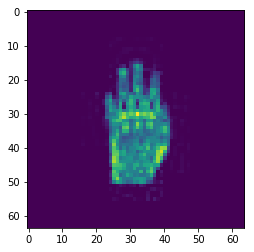

In [39]:
reference = imread("64x64_hand.jpg")
plt.imshow(reference)

D:\Anaconda2\envs\py3.6\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


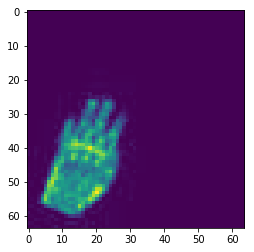

In [40]:
template = imread("64x64_225_Topleft.jpg")
plt.imshow(template)

### 3. Gradient Descent

3734918.8319187225
3734886.3779923595
3734876.8305324567
3734874.138019842
3734873.1621802086
3734872.266116895
3734871.444206941
3734870.688654533
3734869.9957017256
3734869.361110705
3734868.730183965
3734868.2998128026
3734868.0164221954
3734867.7440793663
3734867.482254027
3734867.2303980016
3734866.987387693
3734866.7498310604
3734866.422599946
3734866.068549943


D:\Anaconda2\envs\py3.6\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3734865.7282905653
3734865.40114187
3734865.086464089
3734864.7836541357
3734864.4921350256
3734864.2113710027
3734863.9408598742
3734863.680127332
3734863.4287251406
3734863.1862294665


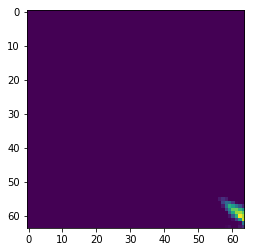

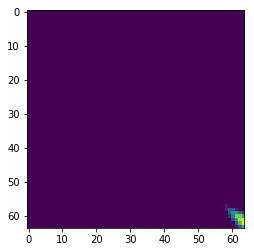

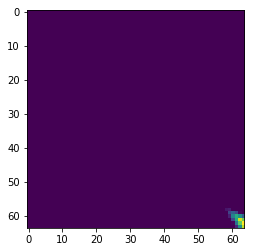

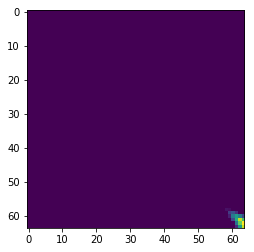

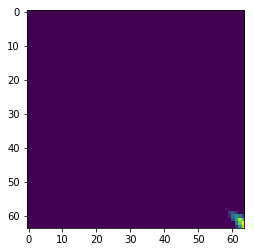

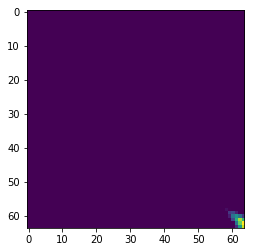

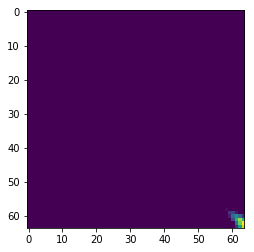

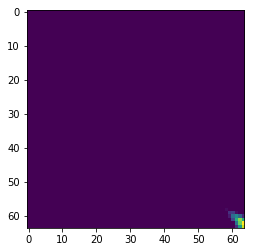

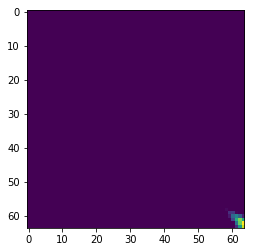

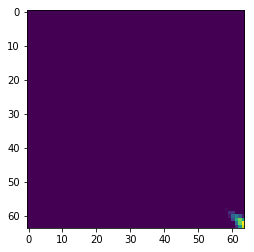

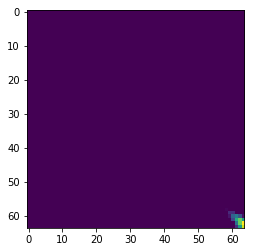

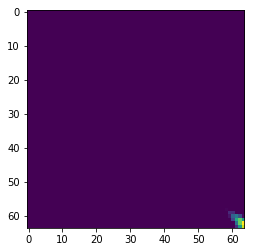

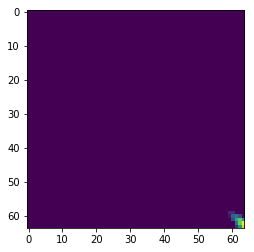

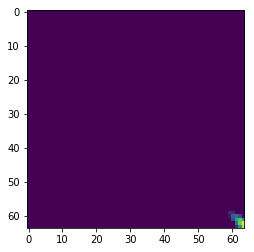

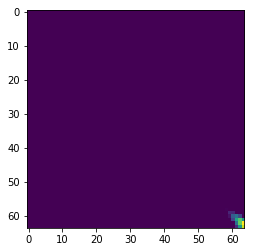

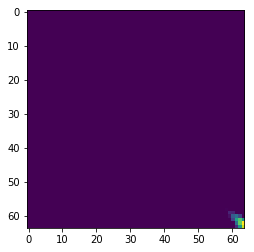

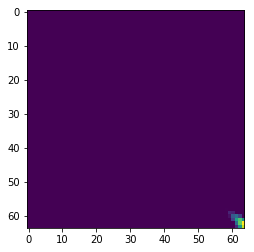

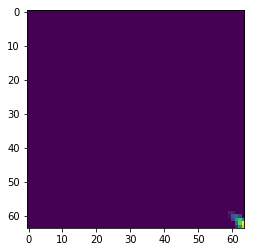

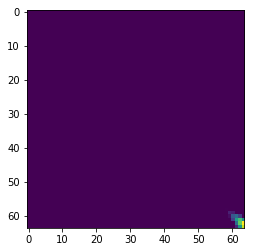

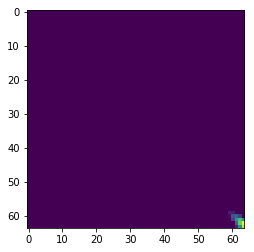

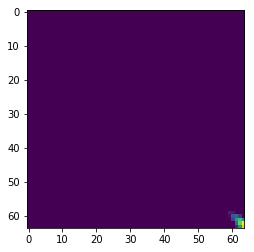

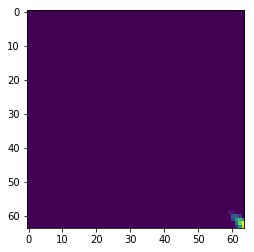

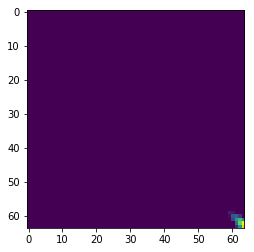

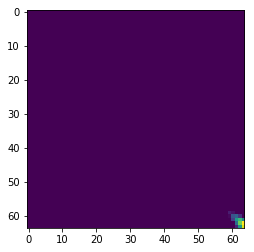

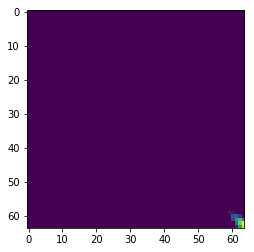

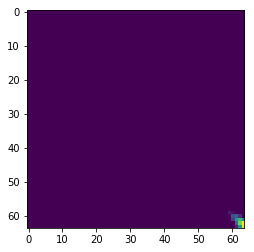

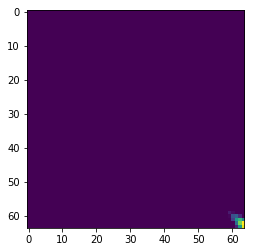

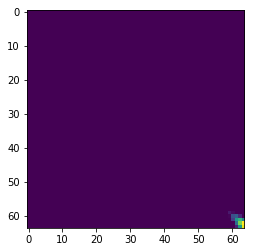

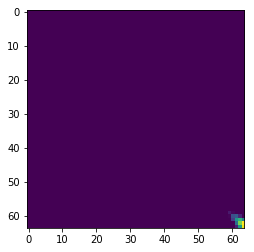

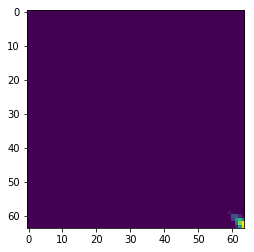

In [42]:
transMatrix = np.array([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])
lr = 1e-9
i = 0
iteration = 3000
while i < iteration:
    moving, dTx, dTy = biInterpolate(template, transMatrix)
    delta_weights = calGradient(reference, moving, dTx, dTy, lr)
    transMatrix -= delta_weights
    loss = calLoss(moving, reference)
    i += 1
    if i%100 == 0:
        plt.figure(i//100)
        plt.imshow(moving)
        print(loss)



In [43]:
print(transMatrix)

[[ 7.94808529e-01 -4.82923366e-01 -8.93390670e-01]
 [-2.18275710e-01  5.09171446e-01 -9.21423652e-01]
 [ 0.00000000e+00  0.00000000e+00 -2.99900000e+03]]
